# 00 Exploratory Analysis

### Purpose
This folder contains the initial exploratory data analysis (EDA) performed on the fluid simulation dataset. The goal is to understand the statistical properties, variability, and structural patterns within each channel (u, v, p, ω) before training the autoencoder models. This analysis helps identify which features contain the most turbulent information and which channels are easier or harder to reconstruct.

### Contents
- Python scripts and notebooks used to compute summary statistics across all Reynolds numbers.
- Plots showing:
  - Mean values per channel vs. Reynolds number  
  - Standard deviation per channel vs. Reynolds number  
  - High-frequency content ratios across channels  
- Any intermediate data files generated during the analysis.

### Outputs
- Saved figures in `.png` format summarizing mean, variance, and high-frequency behavior across channels.
- Summary tables containing computed statistics for each Reynolds number.
- Observational notes that guide model design and inform which channels require the most careful reconstruction.


In [72]:
import numpy as np
import matplotlib.pyplot as plt
import os, re, glob
import pandas as pd

output_dir = "../OUTPUTS/00_exploratory_analysis"
os.makedirs(output_dir, exist_ok=True)

base_dir = "../DATA/NavierStokes"
folders = ["train", "test"]

## Mean and Standard Deviation of Each Channel

In [73]:
stats = {"Re": [], "mean_u": [], "std_u": [], "mean_v": [], "std_v": [],
         "mean_p": [], "std_p": [], "mean_w": [], "std_w": []}

for folder in folders:
    path = os.path.join(base_dir, folder)
    for f in os.listdir(path):
        if f.endswith(".npy"):
            Re = int(re.findall(r'\d+', f)[0])  
            data = np.load(os.path.join(path, f))
            means = data.mean(axis=(0,2,3))   # mean for each channel
            stds = data.std(axis=(0,2,3))     # std for each channel
            stats["Re"].append(Re)
            stats["mean_u"].append(means[0]); stats["std_u"].append(stds[0])
            stats["mean_v"].append(means[1]); stats["std_v"].append(stds[1])
            stats["mean_p"].append(means[2]); stats["std_p"].append(stds[2])
            stats["mean_w"].append(means[3]); stats["std_w"].append(stds[3])

df = pd.DataFrame(stats).sort_values("Re")


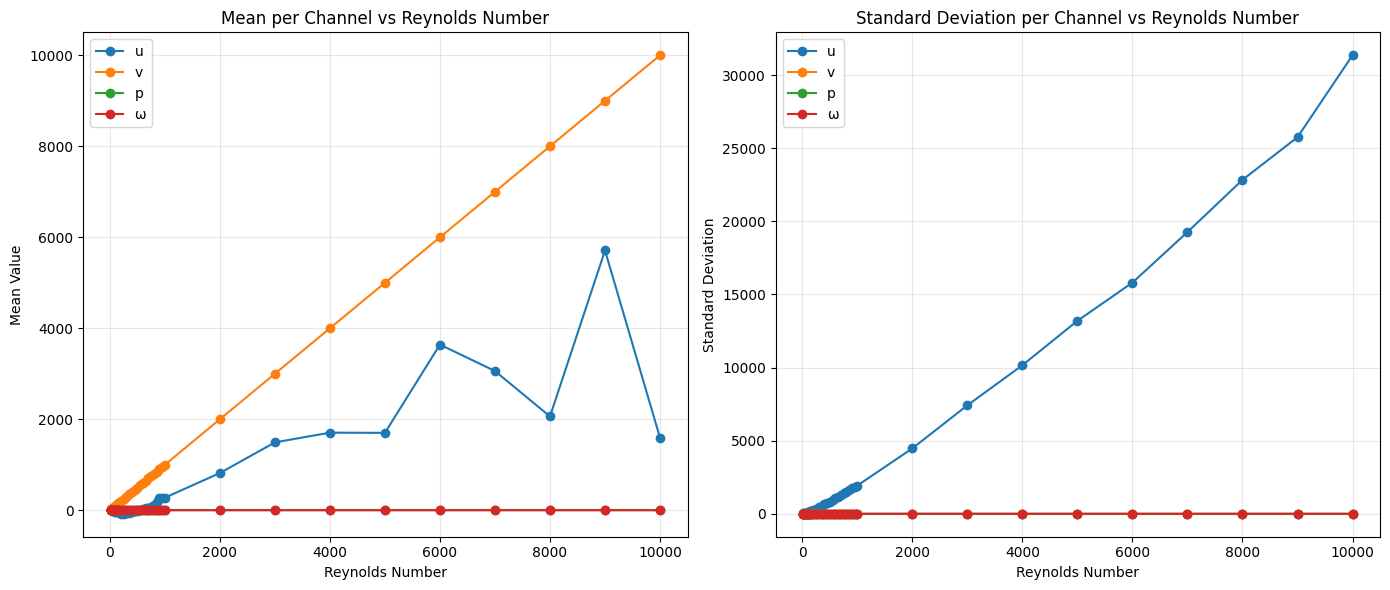

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Left plot: MEANS
for ch, label in zip(
    ["mean_u", "mean_v", "mean_p", "mean_w"],
    ["u", "v", "p", "ω"]
):
    axes[0].plot(df["Re"], df[ch], marker="o", label=label)

axes[0].set_title("Mean per Channel vs Reynolds Number")
axes[0].set_xlabel("Reynolds Number")
axes[0].set_ylabel("Mean Value")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: STDs
for ch, label in zip(
    ["std_u", "std_v", "std_p", "std_w"],
    ["u", "v", "p", "ω"]
):
    axes[1].plot(df["Re"], df[ch], marker="o", label=label)

axes[1].set_title("Standard Deviation per Channel vs Reynolds Number")
axes[1].set_xlabel("Reynolds Number")
axes[1].set_ylabel("Standard Deviation")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

output_path = "../OUTPUTS/00_exploratory_analysis/mean_std_vs_re.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()


This figure summarizes how both the mean (average values) and the standard deviation (variability) of each fluid channel change as the Reynolds number increases. The left plot shows that the velocity components (u and v) increase sharply with Re, reflecting stronger and faster flow as turbulence develops, while pressure and vorticity (p and ω) remain near zero, indicating symmetric fluctuations rather than a directional trend. The right plot shows only the u grows significantly with Re, suggesting that most of the turbulent intensity in the dataset is expressed through fluctuations in the x-direction velocity field, while v, p, and  ω remain nearly constant with minimal variance. Together, these patterns confirm the physical consistency of the dataset and highlight that turbulence-driven variability is concentrated primarily in u, whereas the other channels encode smaller-scale, more stable fluctuations that will still contribute important structural information for the autoencoder’s reconstruction.

## Overall High-Frequency Content per Channel (Train + Test)

In [75]:
channels = ["u", "v", "p", "ω"]

def hf_energy_ratio(arr2d, cutoff_frac=0.25):
    """Compute ratio of high-frequency energy (top % of FFT magnitude spectrum)."""
    F = np.fft.fftshift(np.fft.fft2(arr2d))
    P = np.abs(F)**2
    H, W = arr2d.shape
    cy, cx = H//2, W//2
    y = np.arange(H) - cy
    x = np.arange(W) - cx
    Y, X = np.meshgrid(y, x, indexing="ij")
    r = np.sqrt(X**2 + Y**2)
    r_norm = r / r.max()
    hf_mask = r_norm >= (1.0 - cutoff_frac)
    return P[hf_mask].sum() / (P.sum() + 1e-12)

ratios = np.zeros(4)
counts = np.zeros(4)

for folder in folders:
    path = os.path.join(base_dir, folder)
    files = glob.glob(os.path.join(path, "Re_*.npy"))
    for f in files:
        data = np.load(f)  # (T, 4, H, W)
        # Subsample every 6 frames for speed
        for t in range(0, data.shape[0], 6):
            for c in range(4):
                ratios[c] += hf_energy_ratio(data[t, c])
                counts[c] += 1

avg_ratios = ratios / np.maximum(counts, 1)


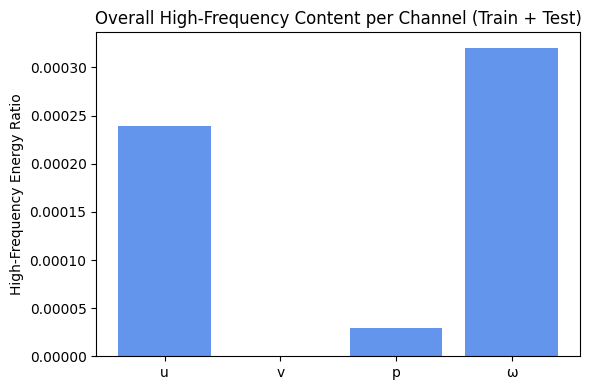

In [76]:
# plot results
plt.figure(figsize=(6,4))
plt.bar(channels, avg_ratios, color="cornflowerblue")
plt.ylabel("High-Frequency Energy Ratio")
plt.title("Overall High-Frequency Content per Channel (Train + Test)")
plt.tight_layout()

output_path = "../OUTPUTS/00_exploratory_analysis/hf_energy_ratios.png"
plt.savefig(output_path, dpi=300, bbox_inches="tight")

plt.show()

This chart shows how much fine detail, or high-frequency content, each channel contained in the dataset. The u channel and the ω channel have the highest ratios, which means they carry many sharp edges, rapid fluctuations, and small-scale structures that are characteristic of turbulent motion. The v channel has almost no high-frequency content, which reflects the fact that it varies very little across the simulations. The p channel has only a small amount of high-frequency energy, indicating that its variations are smoother and change more gradually. Overall, the chart highlights that most of the intricate, rapidly changing patterns in the dataset appear in the u and ω channels, while v and p remain much smoother and less detailed.
